<a href="https://colab.research.google.com/github/diapica/EmotionDetection/blob/main/Model%20Detection%20Emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Library
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import re
import ast

In [ ]:
# Read Dataset
filename = 'Twitter_Emotion_Dataset.csv'
df = pd.read_csv(filename)
orig_df = pd.read_csv(filename)

# Data Understanding

In [ ]:
# About dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4401 entries, 0 to 4400
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4401 non-null   int64 
 1   label       4401 non-null   object
 2   tweet       4401 non-null   object
dtypes: int64(1), object(2)
memory usage: 103.3+ KB


In [ ]:
x = df['label'].unique()
y = df['label'].value_counts()

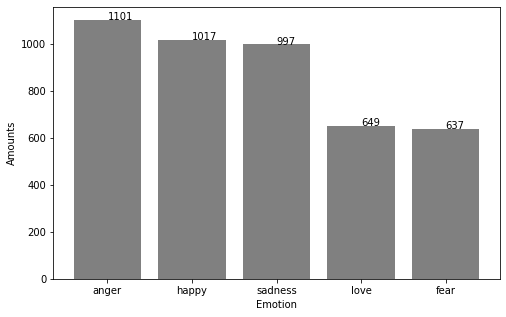

In [ ]:
plt.xlabel('Emotion')
plt.ylabel('Amounts')
plt.bar(x,y, color='gray')
for a,b in zip(x, y): 
    plt.text(a, b, str(b))

plt.gcf().set_size_inches(8, 5)
plt.show()

# Preprocessing

### Data Normalization 


*   Case Folding
*   Remove words, punctuation, whitepace, and number
*   Normalize Alay Words





In [ ]:
def case_folding(text):
  text = text.lower()
  return text

df['tweet'] = df['tweet'].apply(case_folding) 

In [ ]:
substitute_word = ['[username]', '[url]', '[sensitive-no']

def remove_words(text):
  text = ' '.join('' if words in substitute_word else words for words in text.split(' '))
  text = re.sub(r"[^\w\s]", ' ', text)
  text = re.sub(r"\d+", '', text)
  text = text.strip()
  return text

df['tweet'] = df['tweet'].apply(remove_words) 

In [ ]:
# import and made dict for kamus alay to normalize abbreviation and misspelling
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'}) 
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

In [ ]:
new_alay_dict = pd.read_csv('new_ka.csv', encoding='latin-1', header=None)
new_alay_dict = new_alay_dict.rename(columns={0: 'original', 1: 'replacement'}) 
new_alay_dict_map = dict(zip(new_alay_dict['original'], new_alay_dict['replacement']))

In [ ]:
with open("combined_slang.txt", "r") as data:
    combined_slang_map = ast.literal_eval(data.read())

In [ ]:
def normalize_alay(text):         
  text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])          
  text = re.sub('  +', ' ', text)     
  text = ' '.join([combined_slang_map[word] if word in combined_slang_map else word for word in text.split(' ')])          
  text = re.sub('  +', ' ', text)         
  text = ' '.join([new_alay_dict_map[word] if word in new_alay_dict_map else word for word in text.split(' ')])
  text = re.sub('  +', ' ', text)
  return text 

df['tweet'] = df['tweet'].apply(normalize_alay) 

### Stemming

In [ ]:
#!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory_stm = StemmerFactory()
stemmer = factory_stm.create_stemmer()
def stem(text):
  text = stemmer.stem(text)
  return text
  
df['tweet'] = df['tweet'].apply(stem) 

In [ ]:
## Read Dataset
filename = 'stem_emotion_dataset_210506.csv'
df = pd.read_csv(filename)

### Tokenizing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
# Membuat kamus bahasa indonesia untuk indexing dataset nantinya
# Semakin banyak kata yang dimiliki semakin baik
# Kali ini masih menggunakan dataset yang dimiliki sebagai daftar kamus (tweet yang telah di normalisasi & stemming)
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(df['tweet'])

In [ ]:
vocab_size = len(tokenizer.word_index) + 1 #index start from 0
print(vocab_size) 

10717


In [ ]:
# Encode dataset yang kita miliki kedalam index berdasarkan kamus yang dibangun sebelumnya.
data = tokenizer.texts_to_sequences(df['tweet'])
data[0]

[166,
 94,
 3378,
 560,
 4,
 18,
 4951,
 433,
 4952,
 560,
 4,
 167,
 588,
 68,
 400,
 561,
 1448,
 637,
 433,
 166,
 691,
 609,
 166,
 442,
 442,
 4953,
 168,
 349]

In [ ]:
tokenizer.index_word[166]

'soal'

In [ ]:
print("Tweet 1: {0} Kata, Tweet2: {1} Kata".format(len(data[0]), len(data[1])))

Tweet 1: 28 Kata, Tweet2: 35 Kata


In [ ]:
len(data)

4401

In [ ]:
# Memastikan semua data memiliki panjang yang sama (dimensi)
from tensorflow.keras.preprocessing.sequence import pad_sequences
data_pad = pad_sequences(data, padding='post')
print("Tweet 1: {0} Kata, Tweet2: {1} Kata".format(len(data_pad[0]), len(data_pad[1])))

Tweet 1: 85 Kata, Tweet2: 85 Kata


### One Hot Encoding

In [ ]:
label = pd.get_dummies(df['label'])

In [ ]:
# before one hot encoding
df['label'][:5]

0    anger
1    anger
2    happy
3    anger
4    happy
Name: label, dtype: object

In [ ]:
# after one hot encoding
label[:5]

,anger,fear,happy,love,sadness
0,1,0,0,0,0
1,1,0,0,0,0
2,0,0,1,0,0
3,1,0,0,0,0
4,0,0,1,0,0


### Split Data

In [ ]:
# Split data 7:3
from sklearn.model_selection import train_test_split as tts

x_train, x_test, y_train, y_test = tts(data_pad, label, test_size=.3, 
                                       random_state=42, shuffle=True, 
                                       stratify=label)

print("Train data = {0} data \nTest data = {1} ".format(len(x_train), len(x_test)))

Train data = 3080 data 
Test data = 1321 


In [ ]:
y_train_data = y_train.value_counts()
y_train_data

anger  fear  happy  love  sadness
1      0     0      0     0          770
0      0     1      0     0          712
             0      0     1          698
       1     0      0     0          454
       0     0      1     0          446
dtype: int64

In [ ]:
y_test_data = y_test.value_counts()
y_test_data

anger  fear  happy  love  sadness
1      0     0      0     0          331
0      0     1      0     0          305
             0      0     1          299
       1     0      0     0          195
       0     0      1     0          191
dtype: int64

### Original Tweet vs Normalize Tweet

In [ ]:
#Before Stemming
df['tweet'][0]

'soal jalan jatibaru polisi tidak bisa gertak gubernur emangny polisi tidak ikut bahas jangan politik atur wilayah hak gubernur soal tanah abang soal turun turun pelik perlu sabar'

In [ ]:
#After Stemming
df['tweet'][0]

'soal jalan jatibaru polisi tidak bisa gertak gubernur emangny polisi tidak ikut bahas jangan politik atur wilayah hak gubernur soal tanah abang soal turun turun pelik perlu sabar'

# Modeling

### Build Model

In [ ]:
from tensorflow.keras.layers import LSTM
# hyper paramater
embedding_size = 200
lstm_size = 100

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_size, input_length = x_train.shape[1]),
    #tf.keras.layers.Conv1D(filters=50, kernel_size=1, activation='tanh'),
    #tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Bidirectional(LSTM(lstm_size)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='tanh'),
    #tf.keras.layers.Dense(64, activation='tanh'),
    #tf.keras.layers.Dense(32, activation='tanh'),
    #tf.keras.layers.Dense(5, activation='sigmoid',  kernel_regularizer='l2')
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 85, 200)           2143400   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               240800    
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 2,410,573
Trainable params: 2,410,573
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [ ]:
num_epochs = 30

history = model.fit(x_train, y_train, 
                    epochs=num_epochs, 
                    validation_data=(x_test, y_test), verbose=2)

print("Training Complete")

Epoch 1/30
97/97 - 13s - loss: 1.3678 - accuracy: 0.4003 - val_loss: 1.1313 - val_accuracy: 0.5382
Epoch 2/30
97/97 - 3s - loss: 0.7125 - accuracy: 0.7425 - val_loss: 1.0257 - val_accuracy: 0.6064
Epoch 3/30
97/97 - 3s - loss: 0.2864 - accuracy: 0.9091 - val_loss: 1.1842 - val_accuracy: 0.6109
Epoch 4/30
97/97 - 3s - loss: 0.1290 - accuracy: 0.9627 - val_loss: 1.5343 - val_accuracy: 0.5905
Epoch 5/30
97/97 - 3s - loss: 0.0614 - accuracy: 0.9834 - val_loss: 1.7114 - val_accuracy: 0.6003
Epoch 6/30
97/97 - 3s - loss: 0.0290 - accuracy: 0.9922 - val_loss: 2.1086 - val_accuracy: 0.5867
Epoch 7/30
97/97 - 3s - loss: 0.0192 - accuracy: 0.9968 - val_loss: 2.1974 - val_accuracy: 0.5935
Epoch 8/30
97/97 - 3s - loss: 0.0094 - accuracy: 0.9981 - val_loss: 2.1340 - val_accuracy: 0.5942
Epoch 9/30
97/97 - 3s - loss: 0.0173 - accuracy: 0.9951 - val_loss: 2.4599 - val_accuracy: 0.5625
Epoch 10/30
97/97 - 3s - loss: 0.0357 - accuracy: 0.9886 - val_loss: 2.2589 - val_accuracy: 0.5836
Epoch 11/30
97/97 

# Evaluation

### Accuracy & Loss Compare

<Figure size 432x288 with 0 Axes>

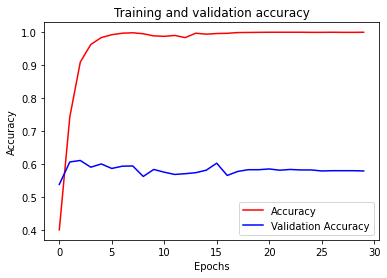

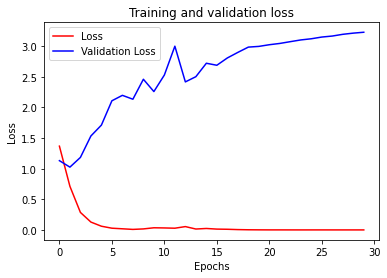

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!

### Confusion Matrix / Classification matrix

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test, batch_size=64, verbose=2)
y_pred_bool = np.argmax(y_pred, axis=1)
#print(classification_report(y_test, y_pred_bool))
y_pred_bool

21/21 - 1s


array([4, 4, 3, ..., 3, 2, 0])

In [ ]:
y_test_data = y_test
y_test_data.columns = [0, 1, 2, 3, 4]
#y_test_data.columns = ['anger', 'fear',	'happy',	'love',	'sadness']
y_test_data.idxmax(1)

481     4
3418    4
2917    3
2364    1
1813    0
       ..
3144    0
2553    0
3571    2
3273    2
1065    0
Length: 1321, dtype: int64

In [ ]:
print(classification_report(y_test_data.idxmax(1), y_pred_bool))

              precision    recall  f1-score   support

           0       0.63      0.64      0.63       331
           1       0.64      0.64      0.64       195
           2       0.60      0.55      0.58       305
           3       0.69      0.61      0.65       191
           4       0.42      0.48      0.45       299

    accuracy                           0.58      1321
   macro avg       0.60      0.58      0.59      1321
weighted avg       0.59      0.58      0.58      1321




# Additional: Saved Model, Load Model and Do prediction

In [ ]:
model.save("emotion_detection.h5") # We use this method

In [ ]:
# Load Model
from tensorflow.keras.models import load_model
model_emotion_detection = load_model("emotion_detection.h5")

In [ ]:
# Do Prediction
text = "Hahaha ntah lah, kepengen rapi juga bilang tapi nyinyir bgt. Cari referensi noh di pinterest, buanyaaaak! Ga mesti mahal kok. Sesuaikan budget aja dan tau tempat "

# Change text to format that model can handle
text = text.lower()
substitute_word = ['[username]', '[url]', '[sensitive-no']
text = ' '.join('' if words in substitute_word else words for words in text.split(' '))
text = re.sub(r"[^\w\s]", ' ', text)
text = re.sub(r"\d+", '', text)
text = text.strip()
text

'hahaha ntah lah  kepengen rapi juga bilang tapi nyinyir bgt  cari referensi noh di pinterest  buanyaaaak  ga mesti mahal kok  sesuaikan budget aja dan tau tempat'

In [ ]:
# import and made dict for kamus alay to normalize abbreviation and misspelling
alay_dict = pd.read_csv('new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 1: 'replacement'}) 
alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))

# Normalize Text using Typography Dict
new_alay_dict = pd.read_csv('new_ka.csv', encoding='latin-1', header=None)
new_alay_dict = new_alay_dict.rename(columns={0: 'original', 1: 'replacement'}) 
new_alay_dict_map = dict(zip(new_alay_dict['original'], new_alay_dict['replacement']))

with open("combined_slang.txt", "r") as data:
    combined_slang_map = ast.literal_eval(data.read())

text = ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])          
text = re.sub('  +', ' ', text)     
text = ' '.join([combined_slang_map[word] if word in combined_slang_map else word for word in text.split(' ')])
text = re.sub('  +', ' ', text)         
text = ' '.join([new_alay_dict_map[word] if word in new_alay_dict_map else word for word in text.split(' ')])
text = re.sub('  +', ' ', text)
text

In [ ]:
# Stemming text
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory_stm = StemmerFactory()
stemmer = factory_stm.create_stemmer()

text = stemmer.stem(text)
text

In [ ]:
# Encode & Padding
text = tokenizer.texts_to_sequences([text])
text = pad_sequences(text, padding='post')

In [ ]:
prediction_result = model_emotion_detection(text)
prediction_result = np.argmax(prediction_result, axis=1)
prediction_result

In [ ]:
if prediction_result == 0:
  print('Emotion: Anger')

if prediction_result == 1:
  print('Emotion: Fear')

if prediction_result == 2:
  print('Emotion: Happy')

if prediction_result == 3:
  print('Emotion: Love')

if prediction_result == 4:
  print('Emotion: Sadness')


# CONFUSION MATRIX FOR EACH LABEL 
(ADDITIONAL FOR RESEARCH PURPOSE)
You can ignore this part

In [ ]:
# Split data 7:3
from sklearn.model_selection import train_test_split as tts

_x_train, _x_test, _y_train, _y_test = tts(df['tweet'], df['label'], test_size=.3, 
                                       random_state=42, shuffle=True, 
                                       stratify=label)

print("Train data = {0} data \nTest data = {1} ".format(len(x_train), len(x_test)))

Train data = 3080 data 
Test data = 1321 


In [ ]:
print(_x_test[1105])
print(_y_test[1105])

bahagia birthday sari all the best sehat selalu sukses cita cinta moga sari dan keluarga selalu lindung tuhan amin
happy


In [ ]:
print(y_test[11:20])

      anger  fear  happy  love  sadness
1490      0     0      0     0        1
3108      1     0      0     0        0
1905      1     0      0     0        0
3573      0     0      1     0        0
2359      0     1      0     0        0
1210      0     0      1     0        0
1796      0     0      0     0        1
4030      0     0      1     0        0
2994      0     0      0     0        1


In [ ]:
y_pred_bool[11:20]

array([2, 0, 0, 3, 3, 2, 4, 0, 1])

In [ ]:
y_test_bool = np.argmax(y_test.to_numpy(), axis=1)
#print(classification_report(y_test, y_pred_bool))
y_test_bool

array([4, 4, 3, ..., 2, 2, 0])

In [ ]:
(unique, counts) = np.unique(y_test_bool, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  0, 331],
       [  1, 195],
       [  2, 305],
       [  3, 191],
       [  4, 299]])

In [ ]:
(unique, counts) = np.unique(y_pred_bool, return_counts=True)
frequencies = np.asarray((unique, counts)).T
frequencies

array([[  0, 337],
       [  1, 195],
       [  2, 281],
       [  3, 167],
       [  4, 341]])

In [ ]:
i = 0
sadness = 0
love = 0
happy = 0
fear = 0
anger = 0

_anger = [0, 0, 0, 0, 0]
_fear = [0, 0, 0, 0, 0]
_happy = [0, 0, 0, 0, 0]
_love = [0, 0, 0, 0, 0]
_sadness = [0, 0, 0, 0, 0]

while i < (len(y_test)):
  if y_pred_bool[i] == y_test_bool[i]:
    if y_test_bool[i] == 0:
      _anger[y_pred_bool[i]] += 1

    if y_test_bool[i] == 1:
      _fear[y_pred_bool[i]] += 1

    if y_test_bool[i] == 2:
      _happy[y_pred_bool[i]] += 1

    if y_test_bool[i] == 3:
      _love[y_pred_bool[i]] += 1

    if y_test_bool[i] == 4:
      _sadness[y_pred_bool[i]] += 1

  i+=1



In [ ]:
print("Sadness : ", _sadness)
print("love : ", _love)
print("happy : ", _happy)
print("fear : ", _fear)
print("anger : ", _anger)

Sadness :  [0, 0, 0, 0, 144]
love :  [0, 0, 0, 116, 0]
happy :  [0, 0, 169, 0, 0]
fear :  [0, 124, 0, 0, 0]
anger :  [212, 0, 0, 0, 0]
